# 2. Preprocess WaPOR Precipitation data using python

## 2.1 Clipping to Region of Interest
### Example
To clip raster mapset to a region of interest, a shapefile or the extent coordinate of the ROI is needed.
For example, a shapefile of Wonji command area has been prepared. The code below shows how to get the exent of Wonji.

In [1]:
import shapefile
tg_shp= r"E:\WaPOReg\WonjiGE_SHP\Wonji.shp"
shape = shapefile.Reader(tg_shp)
shape.bbox

[39.21262393877422, 8.332958544964365, 39.32191165240995, 8.453595960742314]

In [2]:
extent=shape.bbox
xmin,ymin,xmax,ymax=extent[0],extent[1],extent[2],extent[3]
xmin,ymin,xmax,ymax

(39.21262393877422, 8.332958544964365, 39.32191165240995, 8.453595960742314)

To get a list of all raster handlers in the folder to be clipped, we can use package *glob* as following.

In [3]:
import glob
input_folder=r'E:\WaPOReg\L3_AETI_AWA_D'
input_fhs=glob.glob(input_folder+'\*.tif')
print('Number of files: {0}'.format(len(input_fhs)))

Number of files: 36


The GDAL excutables *gdal_translate* can be used to quickly clip a raster file to a given extent. The excuteable can be called in command prompt console when its path is added to the environment variables (installment instruction).
Below is an example to clip a raster file in the obtained list of raster handlers. First, the input and output file handlers are defined. Then, using *subprocess* package to run command line with *gdal_translate* in python console. 

In [5]:
import os
output_folder=r'E:\WaPOReg\L3_AETI_AWA_D_clipped'
in_fh=input_fhs[0]
print('in_fh: '+in_fh)
out_fh=os.path.join(output_folder,os.path.split(in_fh)[-1])

import subprocess
string='gdal_translate -of GTiff -ot Float32 -projwin {0} {1} {2} {3} {4} {5}'.format(xmin,ymax,xmax,ymin,in_fh,out_fh)
proc = subprocess.Popen(string, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = proc.communicate()
print(out,err)
print('out_fh: '+out_fh)

in_fh: E:\WaPOReg\L3_AETI_AWA_D\L3_AETI_0901_AWA.tif
('Input file size is 3181, 2541\r\n0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
out_fh: E:\WaPOReg\L3_AETI_AWA_D_clipped\L3_AETI_0901_AWA.tif


### Exercise (2.1)
Clip all the downloaded L3_AETI_AWA_D and L3_APP_AWA_D raster data of Awash-Ethiopia to the extent of ROI (Wonji command area).

**Hint**: 

You can use a for-loop

**for** file **in** list_of_files:
    do something with file    

In [ ]:
'''
Write your code here
'''

In [ ]:
for in_fh in input_fhs:
    out_fh=os.path.join(output_folder,os.path.split(in_fh)[-1])
    string='gdal_translate -of GTiff -ot Float32 -projwin {0} {1} {2} {3} {4} {5}'.format(xmin,ymax,xmax,ymin,in_fh,out_fh)
    proc = subprocess.Popen(string, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = proc.communicate()
    print(out,err,out_fh)

## 2.2 Rescaling using metadata
### Example
The metadata of a dataset contains information about the data such as what is measured, in which unit it is measured, and what is stored in the value. Very often, data is stored in integer *int* format to reduce memory storage space. Thus, to analyze the data as if it is physical values, the stored value must be rescaled, in other words, multiplied with a conversion factor or *multiplier*. For example, the code below is used to get the multiplier of WaPOR AETI dataset **L3_AETI_AWA_D**. Note that the multiplier can be different for different dataset.

In [8]:
import hkvwaporpy as hkv
df=hkv.read_wapor.get_catalogus()

ds_code='L3_AETI_AWA_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]
print(ds_code+' multiplier: {0}'.format(multiplier))

L3_AETI_AWA_D multiplier: 0.1


To multiply the raw data with a multiplier, you can open the mapset as a numerical array and do calculation with this array. The *gdal* package contains functions to work with raster mapset that can be used to do this task. A raster file has many properties including size, nodata value, transform, spatial reference, projection, etc. These information are stored in the dataset and can be read with *gdal* package. Below is the code to get these information from a GeoTIFF file. 

In [21]:
input_folder=r'E:\WaPOReg\L3_AETI_AWA_D'   # E:\WaPORAnalysis\2aL3_AETI_AWA_D_Clipped
input_fhs=glob.glob(input_folder+'\*.tif')

in_fh=input_fhs[0]
print(in_fh)

from osgeo import gdal
DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)

import osr
Type = DataSet.GetDriver().ShortName
bandnumber=1
Subdataset = DataSet.GetRasterBand(bandnumber)
NDV = Subdataset.GetNoDataValue()
xsize = DataSet.RasterXSize
ysize = DataSet.RasterYSize
GeoT = DataSet.GetGeoTransform()
Projection = osr.SpatialReference()
Projection.ImportFromWkt(DataSet.GetProjectionRef())
driver = gdal.GetDriverByName(Type)

print('driver: {0} \nNDV: {1}\nxsize: {2}\nysize: {3}\nGeoT: {4}\nProjection: {5}'.format(
    driver, NDV, xsize, ysize, GeoT, Projection))

E:\WaPOReg\L3_AETI_AWA_D\L3_AETI_0901_AWA.tif
driver: <osgeo.gdal.Driver; proxy of <Swig Object of type 'GDALDriverShadow *' at 0x000000000CA76480> > 
NDV: -9999.0
xsize: 3181
ysize: 2541
GeoT: (518055.0, 30.0, 0.0, 988515.0, 0.0, -30.0)
Projection: PROJCS["WGS 84 / UTM zone 37N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",39],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","32637"]]


The data in *gdal* dataset can be read using *ReadAsArray* function. For example, the below code is used to read the opened GeoTIFF dataset as a numpy array. 
You can plot the data in this array using function in *matplotlib* library. Look at the example code and the output plot below. Notice the spatial actual EvapoTranspiration&Interception of the command area. Keep in mind that this is the raw data which show the average daily AETI in a dekad. Thus, the value in the color bar will be corrected with a multiplier and number of days in the next step.

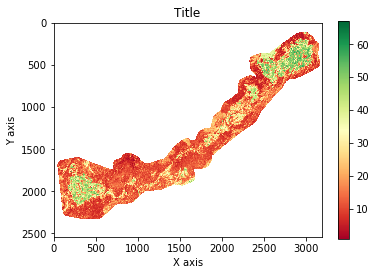

In [29]:
import numpy as np
Array = Subdataset.ReadAsArray().astype(np.float32)
Array[Array == NDV] = np.nan

from matplotlib import pyplot as plt
plt.imshow(Array, cmap='RdYlGn')
plt.colorbar()
plt.title('Title')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()

Normally, a dekad has 10 days except for the last dekad of the month. For example, the last dekad of February can have 8 or 9 days, and the last dekad of January has 11 days. The number of days in the raster period can be calculated when the starting and ending date is known. Recall that in the previous exercise, we can get this information using hkvwaporpy package's function *get_data_availaility*. Below you can see that each raster_id has a starting and ending day.

In [30]:
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2018-12-31]')
df_avail.head()

data_avail_period: DEKAD


,start_dekad,end_dekad,raster_id,bbox_srid,bbox_value
year,,,,,
2009,0101,0110,L3_AETI_0901_AWA,EPSG:32637,"[518055.0, 912285.0, 613485.0, 988515.0]"
2009,0111,0120,L3_AETI_0902_AWA,EPSG:32637,"[518055.0, 912285.0, 613485.0, 988515.0]"
2009,0121,0131,L3_AETI_0903_AWA,EPSG:32637,"[518055.0, 912285.0, 613485.0, 988515.0]"
2009,0201,0210,L3_AETI_0904_AWA,EPSG:32637,"[518055.0, 912285.0, 613485.0, 988515.0]"
2009,0211,0220,L3_AETI_0905_AWA,EPSG:32637,"[518055.0, 912285.0, 613485.0, 988515.0]"


We can access this information and use it to calculate the number of days in the raster period. Below is the example of how to get the number of days in the first raster period in the available data list *df_avail*. You can try to modify the code to do the same calculation for other raster periods.

In [31]:
raster_id=os.path.split(in_fh)[-1].split('.')[0]
print(raster_id)
raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
raster_info

L3_AETI_0901_AWA


,start_dekad,end_dekad,raster_id,bbox_srid,bbox_value
year,,,,,
2009,0101,0110,L3_AETI_0901_AWA,EPSG:32637,"[518055.0, 912285.0, 613485.0, 988515.0]"


In [32]:
start=int(raster_info['start_dekad'].iloc[0])
end=int(raster_info['end_dekad'].iloc[0])
ndays=end-start+1
ndays

10

Once we have the information of conversion factor *multiplier* and number of days *ndays*, we can correct the raw data in raster mapset by multiplying the opened array with these two values. See example below.

multiplier: 0.1
number of days: 10


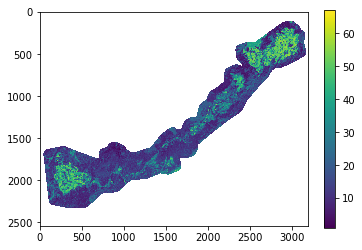

In [33]:
print('multiplier: {0}'.format(multiplier))
print('number of days: {0}'.format(ndays))
CorrectedArray=Array*multiplier*ndays
plt.imshow(CorrectedArray)
plt.colorbar()
plt.show()

To save our result as a raster file (GeoTIFF), we need to know the properties of the original raster file (driver, Nodata Value, size, extent, projection). Below is the example to save the above corrected array as a new raster file.

In [34]:
output_folder=r'E:\WaPOReg\L3_AETI_AWA_D_clipped_corrected'
out_fh=os.path.join(output_folder,raster_id+'.tif')

datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
"int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
"Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    
driver, NDV, xsize, ysize, GeoT, Projection
DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes['float32'])
DataSet.GetRasterBand(1).SetNoDataValue(NDV)
DataSet.SetGeoTransform(GeoT)
DataSet.SetProjection(Projection.ExportToWkt())
DataSet.GetRasterBand(1).WriteArray(CorrectedArray)
print(out_fh)

E:\WaPOReg\L3_AETI_AWA_D_clipped_corrected\L3_AETI_0901_AWA.tif


### Exercise (2.2)
Correct the downloaded NPP data from Exercise 1. 

**Hint**: Make use of the functions in the examples. You can use a for-loop.

**Tips**: You can make your own function with *def* to re-use later 

**def** Function(Inputs):

    Do something with Inputs
    
    return Output

In [ ]:
'''
Write your code here
''' 

In [15]:
import hkvwaporpy as hkv
import glob
import os
from osgeo import gdal
import numpy as np
import osr

def GetRasterInfo(in_fh):
    DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    bandnumber=1
    Subdataset = DataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    xsize = DataSet.RasterXSize
    ysize = DataSet.RasterYSize
    GeoT = DataSet.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(DataSet.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return NDV,xsize,ysize,GeoT,Projection,driver

def OpenRasterAsArray(in_fh,nan_value=True,bandnumber=1,dtype='float32'):  
    SourceDataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)    
    Subdataset = SourceDataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(dtype)
    if nan_value:
        Array[Array == NDV] = np.nan
    return Array

def SaveArrayAsRaster(Array,out_fh,NDV,xsize,ysize,GeoT,Projection,driver,dtype='float32'):
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
    "Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes[dtype])
    if NDV is None:
        NDV=-9999
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    return out_fh

In [ ]:
df=hkv.read_wapor.get_catalogus()
ds_code='L3_NPP_AWA_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2009-12-31]')

### Get multiplier
multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]

### Get input rasters
input_folder=r'E:\WaPOR\L2_AETI_D'               # specify the folder of the directory holding the raster data to be corrected
input_fhs=glob.glob(input_folder+'\*.tif')

output_folder=r'E:\Exercise\1.4\Corrected\L2_AETI_D' # the directory of the folder to save the corrected raster dataset
### Get GeoInfo
in_fh=input_fhs[0]
NDV,xsize,ysize,GeoT,Projection,driver=GetRasterInfo(in_fh)

### Calculation
for in_fh in input_fhs:
    ### Get number of days in raster period
    raster_id=os.path.split(in_fh)[-1].split('.')[0]
    raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
    start=int(raster_info['start_dekad'].iloc[0])
    end=int(raster_info['end_dekad'].iloc[0])
    ndays=end-start+1
    ### Correct raster data with multiplier and number of days
    Array=OpenRasterAsArray(in_fh)
    CorrectedArray=Array*multiplier*ndays
    ### Save corrected array
    out_fh=os.path.join(output_folder,raster_id+'.tif')
    SaveArrayAsRaster(CorrectedArray,out_fh,NDV,xsize,ysize,GeoT,Projection,driver) 
    print(out_fh)